In [1]:
import travel_time_utils as tt
import rvp_utils
import geopandas as gpd
from tqdm import tqdm
import warnings
import datetime as dt
import time
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
warnings.filterwarnings('ignore')
pd.set_option("display.max_rows", 500)

In [10]:
states = "connecticut georgia idaho iowa louisana maine maryland new_hampshire rhode_island utah wisconsin".split()
fips = "09 13 16 19 22 23 24 33 44 49 55".split()
state_fips_dict = dict(zip(states,fips))

In [67]:
%%time
# state_data = {state:{} for state in states
for state in state_fips_dict.keys():
    start = dt.datetime.now()
    if state != 'louisiana':
        continue
    print(f"Working on {state}...")
    fips = state_fips_dict[state]
    
    ### PATHS ###
    KNN_SUM_DM_PATH = f'./20_intermediate_files/{fips}_{state}_knn_sum_dd.dmx'
    DM_PATH = f"./20_intermediate_files/duration_matrix_{state}_{fips}.dmx"
    SHAPEFILE_PATH = f'./Data_2000/Shapefiles/gz_2010_{fips}_500_11_500k/gz_2010_{fips}_500_11_500k.shp'
    rvp_fips = str(int(fips))
    DEM_RVP_PATH = f"RVPs/points_D_{rvp_fips}_2_10000_run1.shp"
    REP_RVP_PATH = f"RVPs/points_R_{rvp_fips}_2_10000_run1.shp"
    
    ### SHAPEFILE ###
    print(" -- Reading CD shapefile into memory...")
    state_shp = gpd.read_file(SHAPEFILE_PATH)
    NUM_CDs = state_shp["CD"].nunique()
    print(f"    -- There are {NUM_CDs} CDs in {state}")
    CDs = {}
    for i in range(1,NUM_CDs+1):
        CD = "{0:0=2d}".format(i)
        CDs[i] = state_shp[state_shp["CD"] == CD]
        
    ### DURATION MATRICES ###
    print(" -- Reading KNN_SUM duration matrix from memory...")
    travel_time_matrix = tt.read_duration_matrix_from_file(KNN_SUM_DM_PATH)
    print(" -- Reading pairwise duration matrix from memory...")
    pairwise_matrix = tt.read_duration_matrix_from_file(DM_PATH)

    ### RVPs ###
    print(" -- Creating RVPs for each CD...")
    rvps_in_CD = {}
    rvps = rvp_utils.sample_rvps(DEM_RVP_PATH, REP_RVP_PATH, NUM_CDs*1000)
    # rvps_in_region = rvp_utils.find_rvps_in_region(state_shp, rvps)
    for i in range(1,NUM_CDs+1):
        rvps_in_CD[i] = rvp_utils.find_rvps_in_region(CDs[i], rvps)
        
#     try:
    ### DISTRICT APTTs ###
    print(" -- Computing district APTTs...")
    district_APTTs = {}
    for i in tqdm(range(1,NUM_CDs+1)):
        ids = tt.return_rvp_ids(rvps_in_CD[i])
        district_APTTs[i] = tt.find_APTT_of_region(ids, pairwise_matrix)

    state_data[state]["district_APTTs"] = district_APTTs

    ### BALL APTTs ####
    print(" -- Computing average ball APTTs")
    average_ball_APTTs = {}
    for i in tqdm(range(1,NUM_CDs+1)):
        ids = tt.return_rvp_ids(rvps_in_CD[i])
        average_ball_APTTs[i] = tt.find_avg_APTT_of_all_balls(ids, pairwise_matrix)

    state_data[state]["average_ball_APTTs"] = average_ball_APTTs
    end = dt.datetime.now()
    print(f"Processing {state} took {end-start}")
#     except:
#         print(f"Encountered an error processing {state}")
#         continue

Working on louisiana...
 -- Reading CD shapefile into memory...
    -- There are 7 CDs in louisiana
 -- Reading KNN_SUM duration matrix from memory...
 -- Reading pairwise duration matrix from memory...
 -- Creating RVPs for each CD...


  0%|          | 0/7 [00:00<?, ?it/s]

 -- Computing district APTTs...


 43%|████▎     | 3/7 [00:00<00:01,  3.94it/s]


IndexError: list index out of range

In [2]:
state_data = pickle.load(open("state_data.p", "rb"))

In [3]:
state_data

{'connecticut': {'district_APTTs': {1: 2432.0639249072506,
   2: 3563.099095184155,
   3: 2736.399416107564,
   4: 2437.9902284712243,
   5: 3406.4121451035544},
  'average_ball_APTTs': {1: 1499.4717324620055,
   2: 2034.3461983671857,
   3: 1583.8757057854757,
   4: 1613.545678658342,
   5: 1772.073193245984}},
 'georgia': {'district_APTTs': {1: 11736.450600808173,
   2: 9605.047008882957,
   3: 8251.047017234454,
   4: 3890.4314074791787,
   5: 3783.656147708307,
   6: 5079.070283513412,
   7: 4051.4607468649197,
   8: 9322.589139786622,
   9: 5462.834190605588,
   10: 6768.385807611605,
   11: 7074.557364547019,
   12: 10855.930082092254,
   13: 7146.821315427307},
  'average_ball_APTTs': {1: 4467.961243836177,
   2: 4350.425957310491,
   3: 2716.7744250089236,
   4: 1463.9904208042944,
   5: 1614.4554662212586,
   6: 2017.8506373970063,
   7: 1987.2093091145998,
   8: 4208.276968652735,
   9: 1956.4148551013204,
   10: 2148.5739605860877,
   11: 2062.8351506409103,
   12: 3347.4341

In [5]:
state="georgia"
fips=13
SHAPEFILE_PATH = f'./Data_2000/Shapefiles/gz_2010_{fips}_500_11_500k/gz_2010_{fips}_500_11_500k.shp'

### SHAPEFILE ###
print(" -- Reading CD shapefile into memory...")
state_shp = gpd.read_file(SHAPEFILE_PATH)
NUM_CDs = state_shp["CD"].nunique()
print(f"    -- There are {NUM_CDs} CDs in {state}")
CDs = {}
for i in range(1,NUM_CDs+1):
    CD = "{0:0=2d}".format(i)
    CDs[i] = state_shp[state_shp["CD"] == CD]

 -- Reading CD shapefile into memory...
    -- There are 13 CDs in georgia


In [40]:
CD_areas = {}
for state in states:
    area_dict = {}
    fips = state_fips_dict[state]
    SHAPEFILE_PATH = f'./Data_2000/Shapefiles/gz_2010_{fips}_500_11_500k/gz_2010_{fips}_500_11_500k.shp'

    ### SHAPEFILE ###
    print(" -- Reading CD shapefile into memory...")
    state_shp = gpd.read_file(SHAPEFILE_PATH)
    NUM_CDs = state_shp["CD"].nunique()
    print(f"    -- There are {NUM_CDs} CDs in {state}")
    CDs = {}
    for i in range(1,NUM_CDs+1):
        CD = "{0:0=2d}".format(i)
        CDs[i] = state_shp[state_shp["CD"] == CD]
        area_dict[i] = CDs[i]["CENSUSAREA"][i-1]
    CD_areas[state] = area_dict

 -- Reading CD shapefile into memory...
    -- There are 5 CDs in connecticut
 -- Reading CD shapefile into memory...
    -- There are 13 CDs in georgia
 -- Reading CD shapefile into memory...
    -- There are 2 CDs in idaho
 -- Reading CD shapefile into memory...
    -- There are 5 CDs in iowa
 -- Reading CD shapefile into memory...
    -- There are 7 CDs in louisana
 -- Reading CD shapefile into memory...
    -- There are 2 CDs in maine
 -- Reading CD shapefile into memory...
    -- There are 8 CDs in maryland
 -- Reading CD shapefile into memory...
    -- There are 2 CDs in new_hampshire
 -- Reading CD shapefile into memory...
    -- There are 2 CDs in rhode_island
 -- Reading CD shapefile into memory...
    -- There are 3 CDs in utah
 -- Reading CD shapefile into memory...
    -- There are 8 CDs in wisconsin


In [41]:
CD_areas['connecticut']

{1: 652.872, 2: 2027.335, 3: 458.01, 4: 456.271, 5: 1247.867}

In [42]:
CD_areas["georgia"]

{1: 11223.403,
 2: 10813.138,
 3: 4098.335,
 4: 328.484,
 5: 245.073,
 6: 677.116,
 7: 962.777,
 8: 7131.704,
 9: 4328.876,
 10: 5851.052,
 11: 2688.263,
 12: 8595.065,
 13: 570.2}

In [43]:
diversity = {
    "connecticut": [0.78, 0.59, 0.72, 0.93, 0.74],
    "georgia": [0.63, 0.62, 0.53, 0.90, 0.99, 0.69, 0.59, 0.64, 0.67, 0.71, 0.63, 0.66, 0.66],
    "idaho": [0.50, 0.59],
    "iowa": [0, 0, 0, 0],
    "louisiana": [0, 0, 0, 0, 0, 0, 0],
    "maine": [0.52, 0.51],
    "maryland": [0.58, 0.73, 0.78, 0.89, 0.71, 0.59, 0.93, 0.96],
    "new_hampshire": [0.56, 0.59],
    "rhode_island": [0.72, 0.72],
    "utah": [0.68, 0.68, 0.62],
    "wisconsin": [0.48, 0.57, 0.52, 0.87, 0.52, 0.47, 0.49, 0.53]
}

In [49]:
ratios, y = [], []
district_APTTs = []
avg_ball_APTTs = []
district_areas = []
for state in state_data.keys():
    if state == "iowa" or state == "louisiana":
        continue
    for district in range(1, len(state_data[state]["district_APTTs"]) + 1):
        if diversity[state][district-1] != 0:
            district_APTT = state_data[state]["district_APTTs"][district]
            avg_ball_APTT = state_data[state]["average_ball_APTTs"][district]
            ratio = district_APTT / avg_ball_APTT
            
            ratios.append(ratio)
            district_APTTs.append(district_APTT)
            avg_ball_APTTs.append(avg_ball_APTT)
            district_areas.append(CD_areas[state][district])
            y.append(diversity[state][district-1])

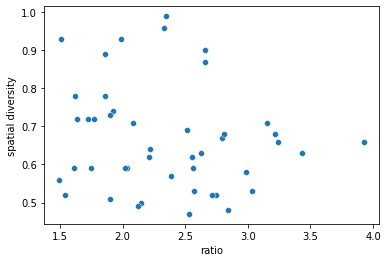

In [51]:
ax = sns.scatterplot(x=ratios, 
                     y=y)
ax.set_xlabel("ratio")
ax.set_ylabel("spatial diversity")
plt.show()

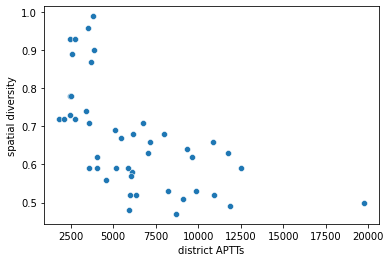

In [52]:
ax = sns.scatterplot(x=district_APTTs, 
                     y=y)
ax.set_xlabel("district APTTs")
ax.set_ylabel("spatial diversity")
plt.show()

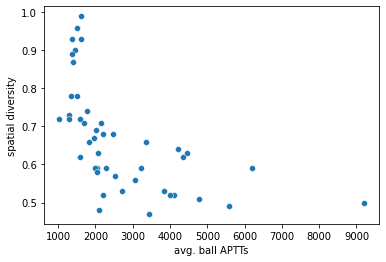

In [53]:
ax = sns.scatterplot(x=avg_ball_APTTs, 
                     y=y)
ax.set_xlabel("avg. ball APTTs")
ax.set_ylabel("spatial diversity")
plt.show()

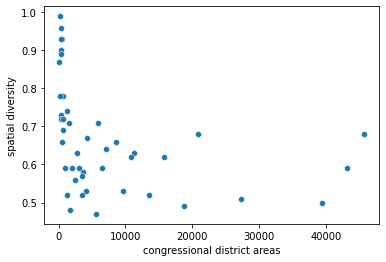

In [54]:
ax = sns.scatterplot(x=district_areas, 
                     y=y)
ax.set_xlabel("congressional district areas")
ax.set_ylabel("spatial diversity")
plt.show()